<a href="https://colab.research.google.com/github/ayla011/DataCampProjects/blob/main/Comprehensive_Diabetes_Clinical_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = '100000-diabetes-clinical-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5420190%2F8998172%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240816%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240816T113803Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D24c1f118d68721ebd01569d84289f9aa2ef7af3d468321c3847ba719a13ff02fdf8ef9615431e55c92e5ac6bec9c0e32be1cd46708088bfddc8c8ed0d508aaf3514f6b628f8194938ac4e1e47d500fda90e685ff2f460a4e8895e68fe2c78a24137d0aff2ef1bf71c147669ac48904c9a36a1971f8ec87109deae33f94d16a4124a5585fbb983a85d5f6b1659b42869360189a2f1629f76273c70928efd2e9eac1542274c0a28d0aeed6f3111ebd8b209ca599757e1c380947a6f95f3ed2a17d6e7265ef0cccffaf634fa15d250b7a98af32d6fcf8fc0c6fcfd5aca96d0c86d78b815f903706804977559ba66d5391637ada2bc1f0584cad00c34f1cfdf33cdc'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 917848 bytes downloaded
Downloaded and uncompressed: 100000-diabetes-clinical-dataset
Data source import complete.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

In [3]:
df = pd.read_csv("/kaggle/input/100000-diabetes-clinical-dataset/diabetes_dataset.csv")

In [4]:
df.head()

,year,gender,age,location,race:AfricanAmerican,race:Asian,race:Caucasian,race:Hispanic,race:Other,hypertension,heart_disease,smoking_history,bmi,hbA1c_level,blood_glucose_level,diabetes
0,2020,Female,32.0,Alabama,0,0,0,0,1,0,0,never,27.32,5.0,100,0
1,2015,Female,29.0,Alabama,0,1,0,0,0,0,0,never,19.95,5.0,90,0
2,2015,Male,18.0,Alabama,0,0,0,0,1,0,0,never,23.76,4.8,160,0
3,2015,Male,41.0,Alabama,0,0,1,0,0,0,0,never,27.32,4.0,159,0
4,2016,Female,52.0,Alabama,1,0,0,0,0,0,0,never,23.75,6.5,90,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   year                  100000 non-null  int64  
 1   gender                100000 non-null  object 
 2   age                   100000 non-null  float64
 3   location              100000 non-null  object 
 4   race:AfricanAmerican  100000 non-null  int64  
 5   race:Asian            100000 non-null  int64  
 6   race:Caucasian        100000 non-null  int64  
 7   race:Hispanic         100000 non-null  int64  
 8   race:Other            100000 non-null  int64  
 9   hypertension          100000 non-null  int64  
 10  heart_disease         100000 non-null  int64  
 11  smoking_history       100000 non-null  object 
 12  bmi                   100000 non-null  float64
 13  hbA1c_level           100000 non-null  float64
 14  blood_glucose_level   100000 non-null  int64  
 15  d

In [6]:
df.describe()

,year,age,race:AfricanAmerican,race:Asian,race:Caucasian,race:Hispanic,race:Other,hypertension,heart_disease,bmi,hbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,2018.360820,41.885856,0.202230,0.200150,0.198760,0.19888,0.199980,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,1.345239,22.516840,0.401665,0.400114,0.399069,0.39916,0.399987,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,2015.000000,0.080000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,2019.000000,24.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,2019.000000,43.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,2019.000000,60.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,2022.000000,80.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


# **Exploratory Data Analysis**

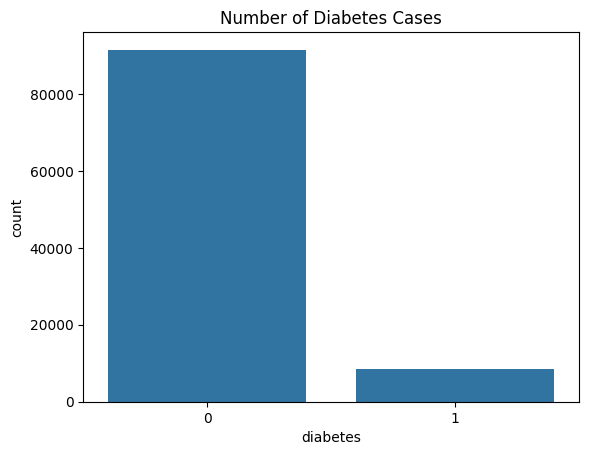

In [7]:
sns.reset_defaults()
d = sns.countplot(data = df, x = "diabetes")
d.set_title("Number of Diabetes Cases")
plt.show()

In [8]:
yearly = df.groupby("year")["diabetes"].agg("sum").reset_index()
yearly

,year,diabetes
0,2015,759
1,2016,765
2,2018,243
3,2019,6727
4,2020,3
5,2021,1
6,2022,2


In [9]:
p = df.diabetes.sum()/len(df)*100
print("Percentage of diabetes patients: ", p, "%")

Percentage of diabetes patients:  8.5 %


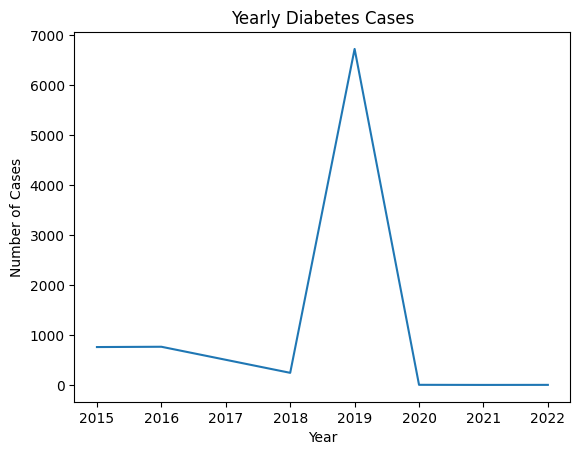

In [10]:
y = sns.lineplot(data = yearly, x = "year", y = "diabetes")
y.set_title("Yearly Diabetes Cases")
y.set_xlabel("Year")
y.set_ylabel("Number of Cases")
plt.show()

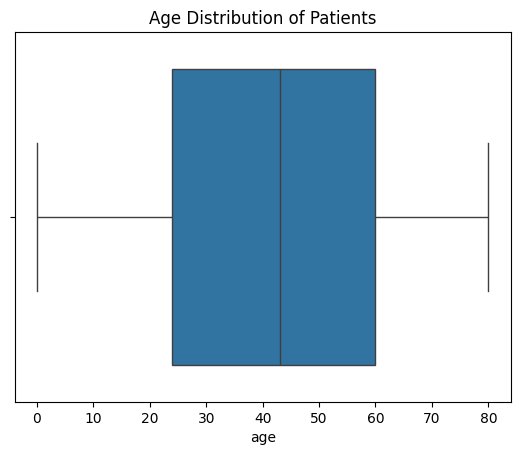

In [11]:
a = sns.boxplot(data = df, x = "age")
a.set_title("Age Distribution of Patients")
plt.show()

In [12]:
df.age.std()

22.51683987161702

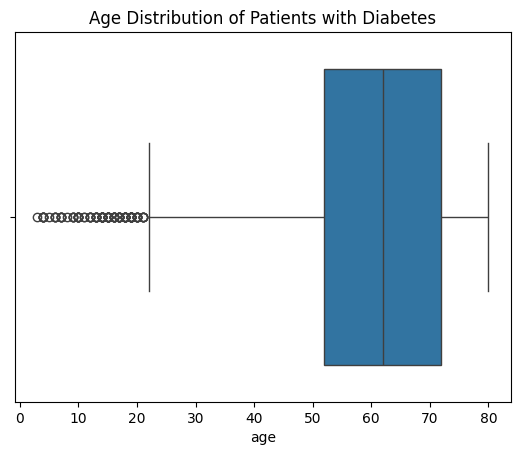

In [13]:
ad = sns.boxplot(data = df[df["diabetes"] == 1], x = "age")
ad.set_title("Age Distribution of Patients with Diabetes")
plt.show()

In [14]:
loc = df.location.value_counts(dropna = False).reset_index()
loc

,location,count
0,Iowa,2038
1,Nebraska,2038
2,Kentucky,2038
3,Hawaii,2038
4,Florida,2037
5,Minnesota,2037
6,New Jersey,2037
7,Arkansas,2037
8,Delaware,2036
9,Kansas,2036


In [15]:
dloc = df.groupby("location")["diabetes"].agg("sum").reset_index().sort_values("diabetes", ascending = False)
dloc

,location,diabetes
7,Delaware,200
17,Kansas,199
14,Illinois,195
27,Montana,194
41,Rhode Island,192
18,Kentucky,192
12,Hawaii,186
32,New Mexico,184
25,Mississippi,184
21,Maryland,184


In [16]:
df_race = df[["race:AfricanAmerican", "race:Asian", "race:Caucasian", "race:Hispanic", "race:Other"]]
by_race = pd.from_dummies(df_race)
df2 = df.drop(columns = ["race:AfricanAmerican", "race:Asian", "race:Caucasian", "race:Hispanic", "race:Other"])
df2.insert(2, "race", by_race)
df2["race"] = df2["race"].str.replace("race:", "")

In [17]:
bins = [0, 18, 25, 35, 45, 55, 65, np.inf]
names = ["0-18", "18-24", "25-34", "35-44", "45-54", "55-64", "65+"]
df2.insert(3, "age_cat", pd.cut(df2["age"], bins, labels = names))

In [18]:
bins = [0, 18.5, 25, 30, np.inf]
names = ["underweight", "normal", "overweight", "obese"]
df2.insert(9, "bmi_cat", pd.cut(df2["bmi"], bins, labels = names))

In [19]:
df2.columns

Index(['year', 'gender', 'race', 'age_cat', 'age', 'location', 'hypertension',
       'heart_disease', 'smoking_history', 'bmi_cat', 'bmi', 'hbA1c_level',
       'blood_glucose_level', 'diabetes'],
      dtype='object')

<Figure size 600x600 with 0 Axes>

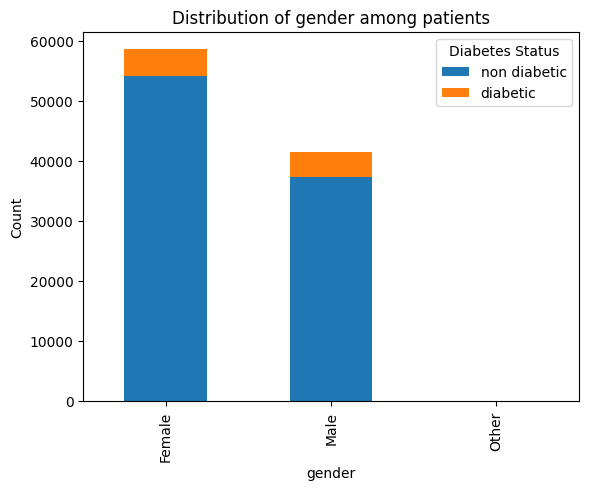

<Figure size 600x600 with 0 Axes>

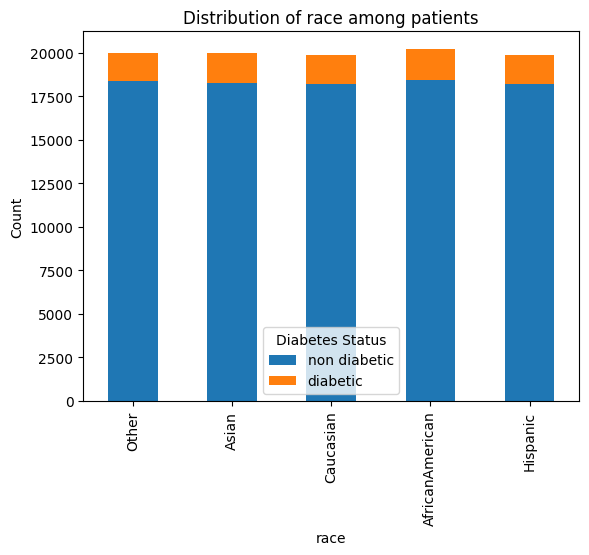

<Figure size 600x600 with 0 Axes>

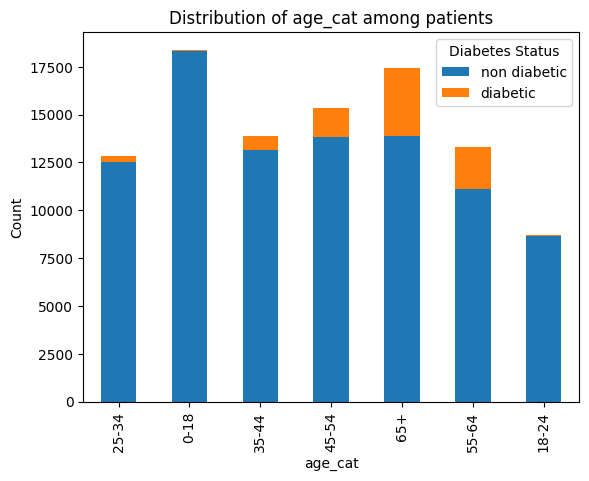

<Figure size 600x600 with 0 Axes>

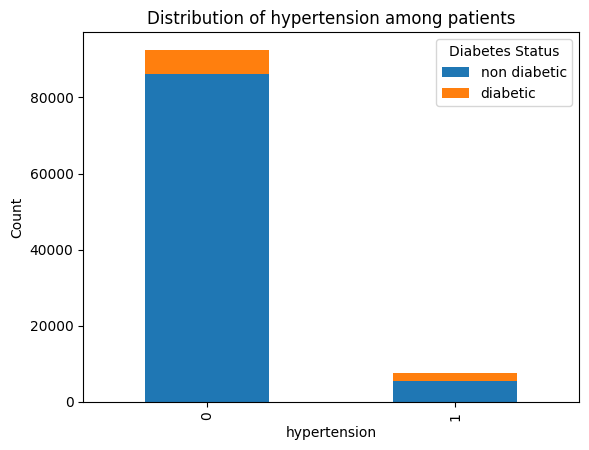

<Figure size 600x600 with 0 Axes>

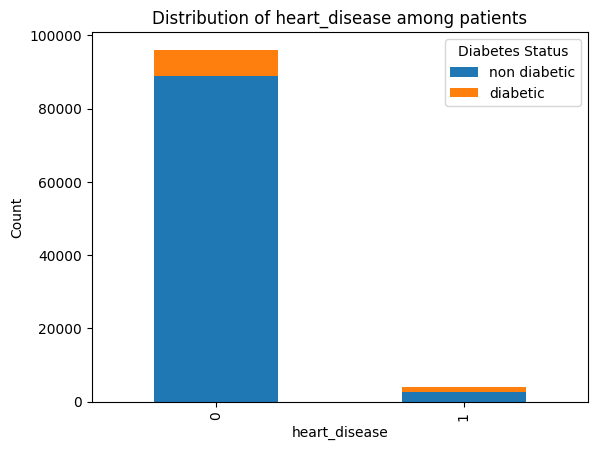

<Figure size 600x600 with 0 Axes>

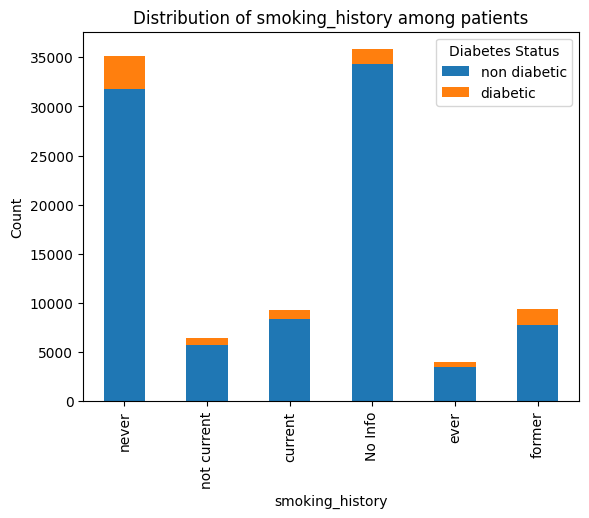

<Figure size 600x600 with 0 Axes>

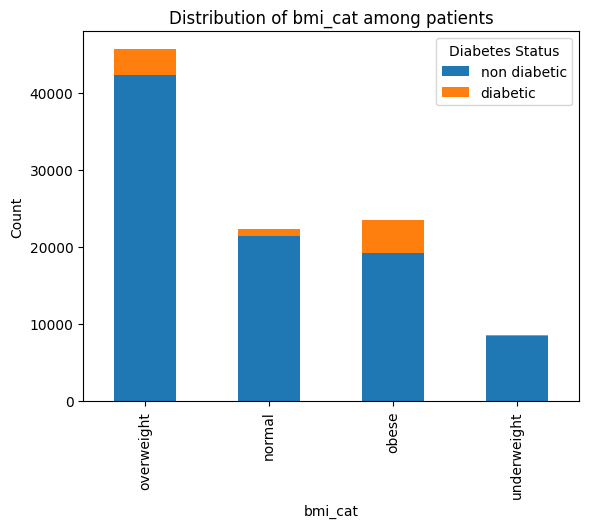

In [43]:
columns = ['gender', 'race', 'age_cat', 'hypertension', 'heart_disease', 'smoking_history', 'bmi_cat']

for col in columns:
    # Get unique categories for the column
    categories = list(df2[col].unique())

    non_diabetic_counts = []
    diabetic_counts = []

    for cat in categories:
        non_diabetic = df2[(df2[col] == cat) & (df2["diabetes"] == 0)].shape[0]
        diabetic = df2[(df2[col] == cat) & (df2["diabetes"] == 1)].shape[0]

        non_diabetic_counts.append(non_diabetic)
        diabetic_counts.append(diabetic)

    d = pd.DataFrame({
        col: categories,
        "non diabetic": non_diabetic_counts,
        "diabetic": diabetic_counts
    })
    plt.figure(figsize=(6, 6))
    d.plot(x=col, kind="bar", stacked=True)
    plt.title(f"Distribution of {col} among patients")
    plt.xlabel(f"{col}")
    plt.ylabel("Count")
    plt.legend(title="Diabetes Status")
    plt.show()

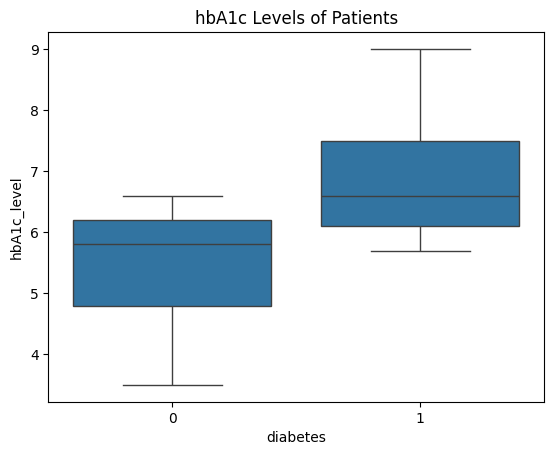

In [21]:
hd = sns.boxplot(data = df, x = "diabetes", y = "hbA1c_level")
hd.set_title("hbA1c Levels of Patients")
plt.show()

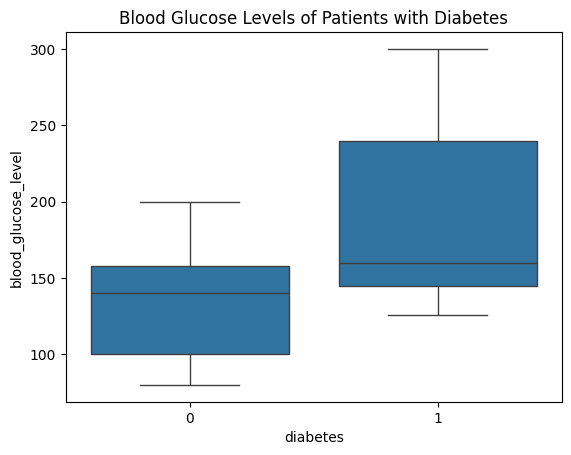

In [22]:
bgd = sns.boxplot(data = df, x = "diabetes", y = "blood_glucose_level")
bgd.set_title("Blood Glucose Levels of Patients with Diabetes")
plt.show()

# Encoding Categorical Data

In [23]:
df_encoded = df2.drop(columns = "age_cat")
le = LabelEncoder()

df_encoded["gender"] = le.fit_transform(df_encoded["gender"])
df_encoded["location"] = le.fit_transform(df_encoded["location"])
df_encoded["race"] = le.fit_transform(df_encoded["race"])
df_encoded["bmi_cat"] = le.fit_transform(df_encoded["bmi_cat"])
df_encoded["smoking_history"] = le.fit_transform(df_encoded["smoking_history"])
df_encoded

,year,gender,race,age,location,hypertension,heart_disease,smoking_history,bmi_cat,bmi,hbA1c_level,blood_glucose_level,diabetes
0,2020,0,4,32.0,0,0,0,4,2,27.32,5.0,100,0
1,2015,0,1,29.0,0,0,0,4,0,19.95,5.0,90,0
2,2015,1,4,18.0,0,0,0,4,0,23.76,4.8,160,0
3,2015,1,2,41.0,0,0,0,4,2,27.32,4.0,159,0
4,2016,0,0,52.0,0,0,0,4,0,23.75,6.5,90,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2018,0,4,33.0,54,0,0,4,0,21.21,6.5,90,0
99996,2016,0,1,80.0,54,0,0,0,1,36.66,5.7,100,0
99997,2018,1,1,46.0,54,0,0,2,1,36.12,6.2,158,0
99998,2018,0,0,51.0,54,0,0,5,2,29.29,6.0,155,0


In [24]:
corr_mat = df_encoded.corr()
corr_mat

,year,gender,race,age,location,hypertension,heart_disease,smoking_history,bmi_cat,bmi,hbA1c_level,blood_glucose_level,diabetes
year,1.000000,0.001104,0.003852,-0.003304,-0.062219,-0.003806,0.001820,-0.006519,-0.001978,-0.001861,-0.000465,0.002968,-0.003464
gender,0.001104,1.000000,-0.000254,-0.030656,-0.001573,0.014203,0.077696,-0.077919,0.097524,-0.022994,0.019957,0.017199,0.037411
race,0.003852,-0.000254,1.000000,-0.003421,0.002335,-0.002677,-0.003563,-0.005476,-0.001186,-0.002497,0.001059,-0.004308,-0.006781
age,-0.003304,-0.030656,-0.003421,1.000000,0.005388,0.251171,0.233354,0.228608,-0.120291,0.337396,0.101354,0.110672,0.258008
location,-0.062219,-0.001573,0.002335,0.005388,1.000000,0.005723,0.004388,0.003602,-0.000344,-0.000210,0.003106,0.002670,-0.000130
hypertension,-0.003806,0.014203,-0.002677,0.251171,0.005723,1.000000,0.121262,0.093177,-0.030421,0.147666,0.080939,0.084429,0.197823
heart_disease,0.001820,0.077696,-0.003563,0.233354,0.004388,0.121262,1.000000,0.027598,-0.014086,0.061198,0.067589,0.070066,0.171727
smoking_history,-0.006519,-0.077919,-0.005476,0.228608,0.003602,0.093177,0.027598,1.000000,-0.178980,0.179361,0.037369,0.040219,0.094290
bmi_cat,-0.001978,0.097524,-0.001186,-0.120291,-0.000344,-0.030421,-0.014086,-0.178980,1.000000,-0.113877,-0.011063,-0.008705,-0.032563
bmi,-0.001861,-0.022994,-0.002497,0.337396,-0.000210,0.147666,0.061198,0.179361,-0.113877,1.000000,0.082997,0.091261,0.214357


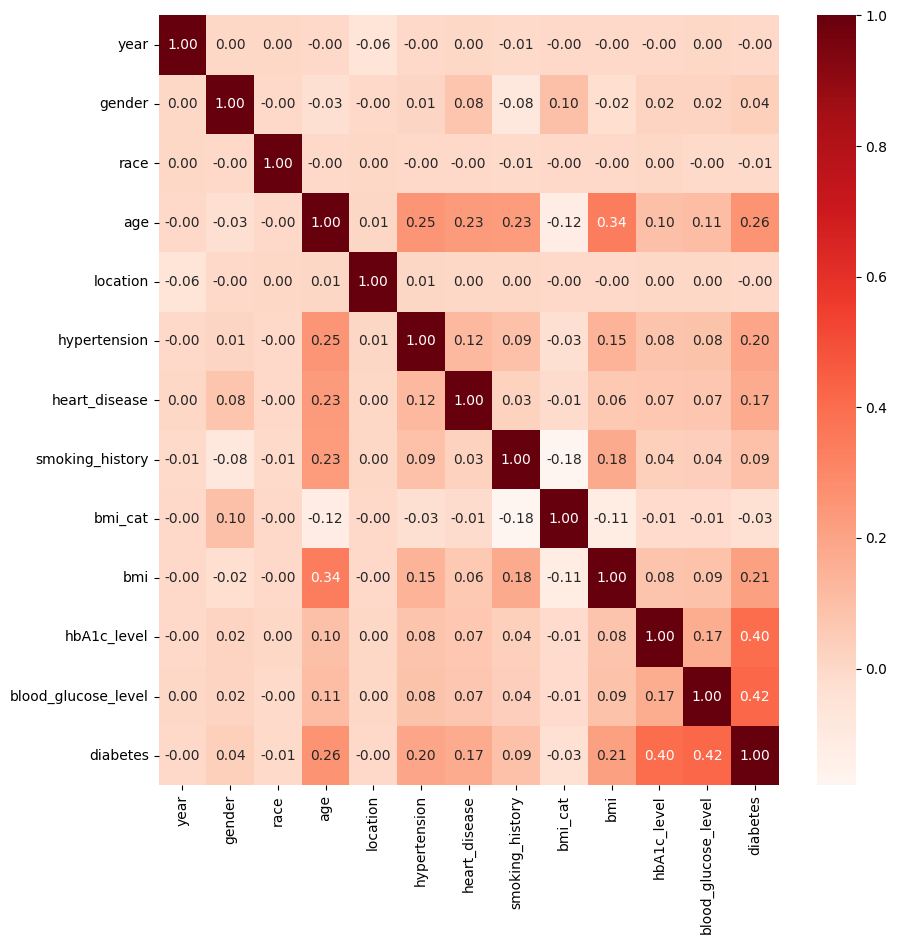

In [25]:
plt.figure(figsize=(10, 10))
sns.heatmap(corr_mat, annot = True, cmap = "Reds", fmt='.2f')
plt.show()

# Drill-down Analysis

<ipython-input-26-48a2e8e8762c>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(["Non-Diabetic", "Diabetic"])


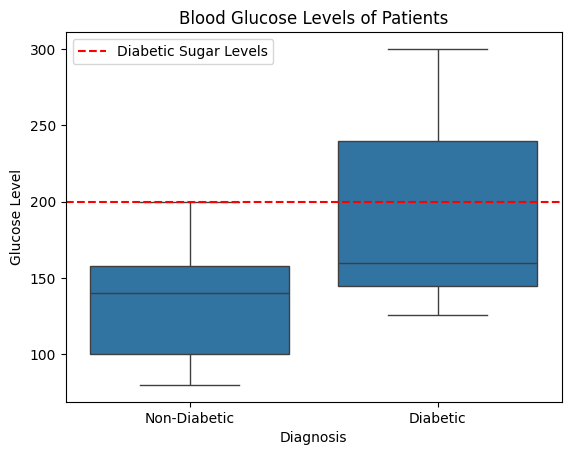

In [26]:
g = sns.boxplot(data = df2, x = "diabetes", y = "blood_glucose_level")
g.set_title("Blood Glucose Levels of Patients")
g.set_xlabel("Diagnosis")
g.set_ylabel("Glucose Level")
g.set_xticklabels(["Non-Diabetic", "Diabetic"])
g.axhline(y = 200, c = "red", ls = "--", label = "Diabetic Sugar Levels")
g.legend()
plt.show()

<ipython-input-27-0d68d0724821>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df2[df2["diabetes"] == 1]["blood_glucose_level"])


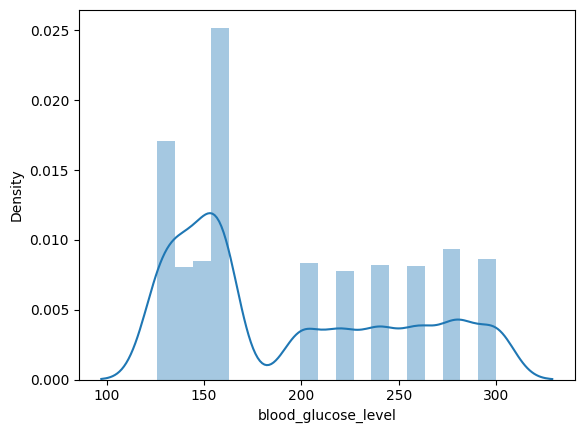

In [27]:
# test for normal distribution
sns.distplot(df2[df2["diabetes"] == 1]["blood_glucose_level"])
plt.show()

<ipython-input-28-5b5c63ab0a17>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df["diabetes"] == 0]["blood_glucose_level"])


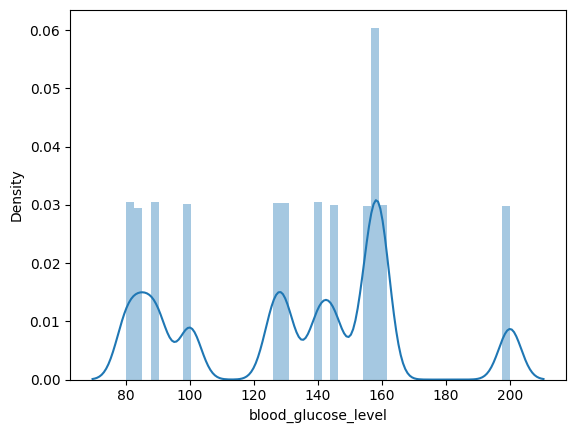

In [28]:
sns.distplot(df[df["diabetes"] == 0]["blood_glucose_level"])
plt.show()

In [29]:
# mwu test at alpha = 0.05
from scipy.stats import mannwhitneyu

stat, pval = mannwhitneyu(df2[df2["diabetes"] == 1]["blood_glucose_level"], df2[df2["diabetes"] == 0]["blood_glucose_level"], alternative='greater')

if pval > 0.05:
    print(f"p-value = {pval}. The blood glucose levels of patients with diabetes are not higher than those with diabetes.")
else:
    print(f"p-value = {pval}. The blood glucose levels of patients with diabetes are higher than those with diabetes.")

p-value = 0.0. The blood glucose levels of patients with diabetes are higher than those with diabetes.


<ipython-input-30-eb20a871370a>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  h.set_xticklabels(["Non-Diabetic", "Diabetic"])


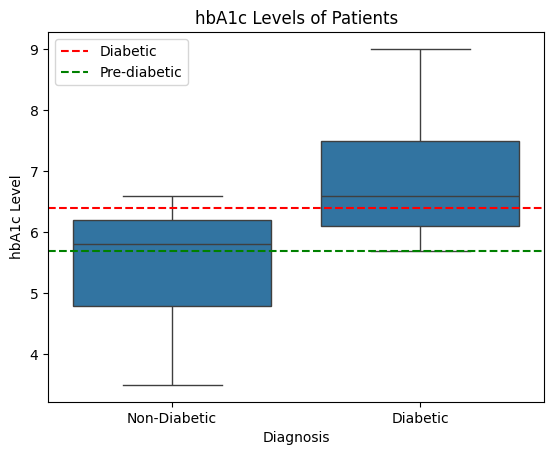

In [30]:
h = sns.boxplot(data = df2, x = "diabetes", y = "hbA1c_level")
h.set_title("hbA1c Levels of Patients")
h.set_xlabel("Diagnosis")
h.set_ylabel("hbA1c Level")
h.set_xticklabels(["Non-Diabetic", "Diabetic"])
h.axhline(y = 6.4, c = "red", ls = "--", label = "Diabetic")
h.axhline(y = 5.7, c = "green", ls = "--", label = "Pre-diabetic")
h.legend()
plt.show()

<ipython-input-31-6fb8a098e5b2>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df2[df2["diabetes"] == 1]["hbA1c_level"])


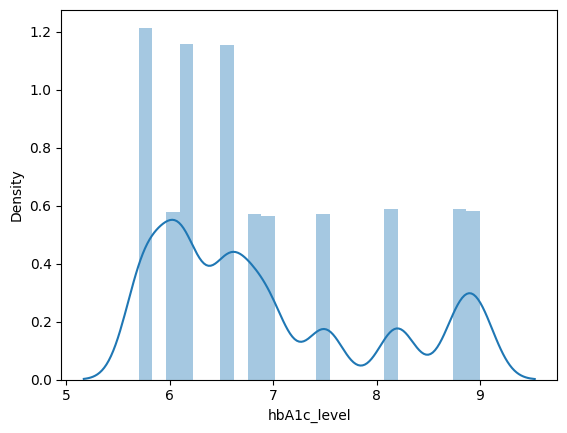

In [31]:
sns.distplot(df2[df2["diabetes"] == 1]["hbA1c_level"])
plt.show()

<ipython-input-32-21002b33b39c>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df2[df2["diabetes"] == 0]["hbA1c_level"])


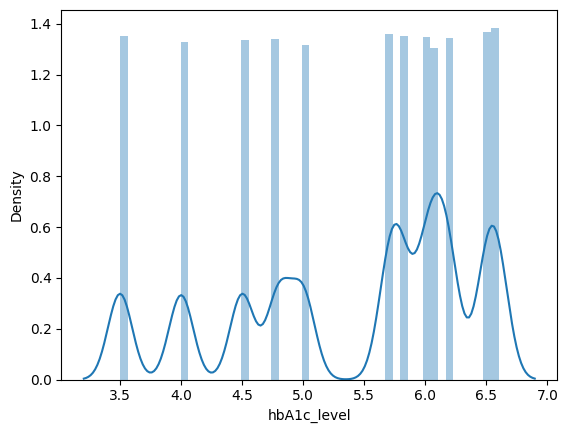

In [32]:
sns.distplot(df2[df2["diabetes"] == 0]["hbA1c_level"])
plt.show()

In [33]:
stat, pval = mannwhitneyu(df2[df2["diabetes"] == 1]["hbA1c_level"], df2[df2["diabetes"] == 0]["hbA1c_level"], alternative='greater')

if pval > 0.05:
    print(f"p-value = {pval}. The hbA1c levels of patients with diabetes are not higher than those with diabetes.")
else:
    print(f"p-value = {pval}. The hbA1c levels of patients with diabetes are higher than those with diabetes.")


p-value = 0.0. The hbA1c levels of patients with diabetes are higher than those with diabetes.


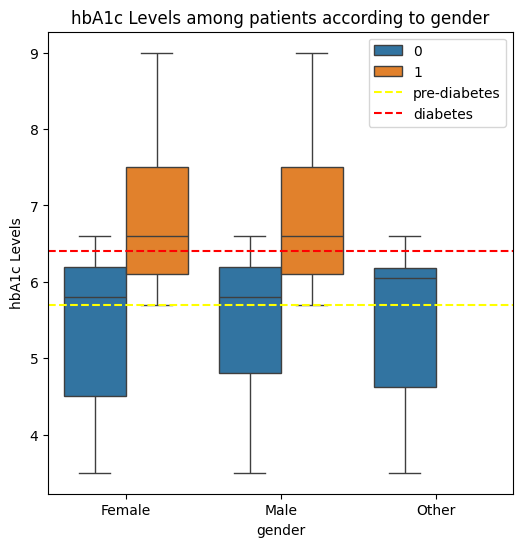

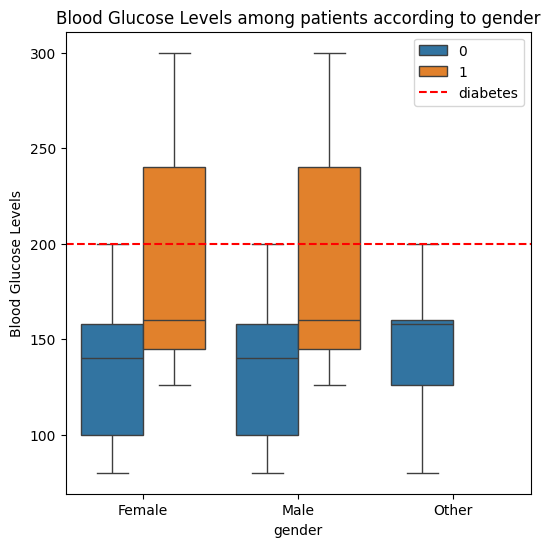

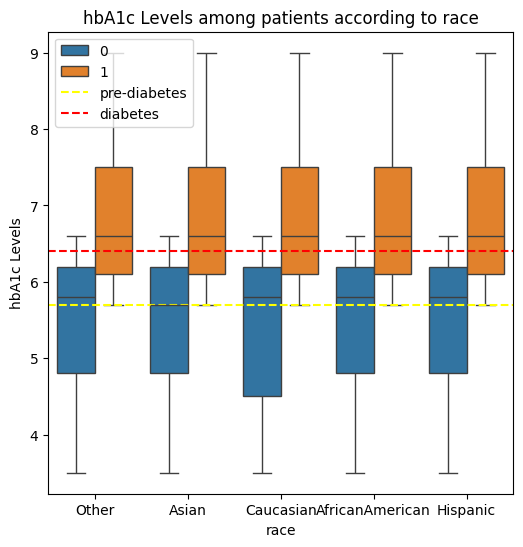

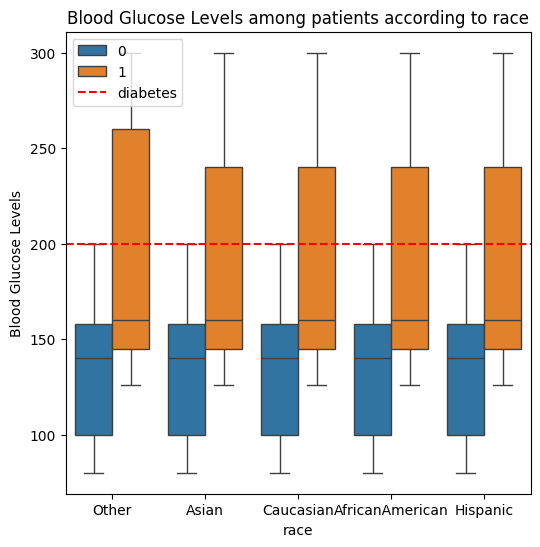

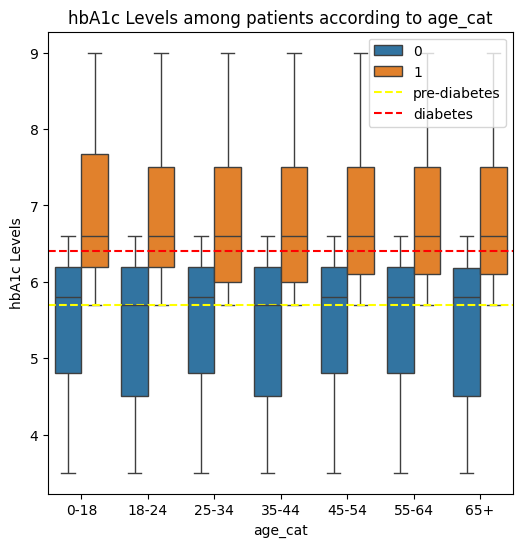

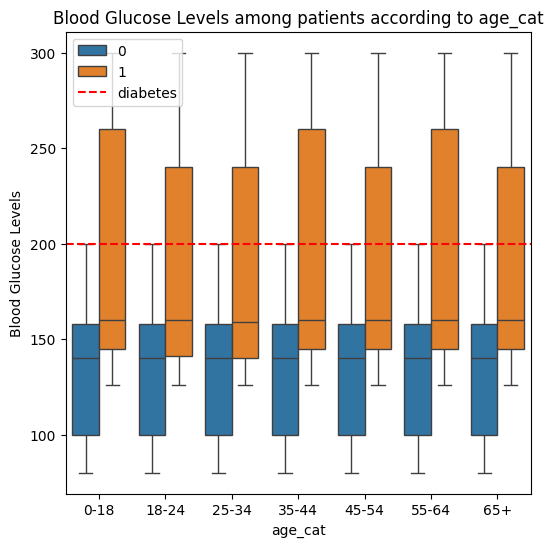

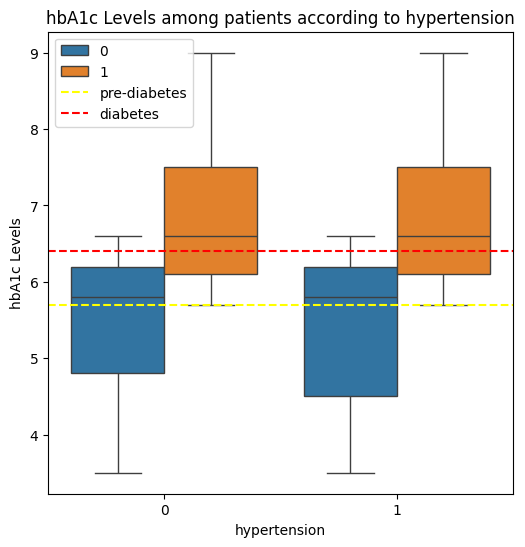

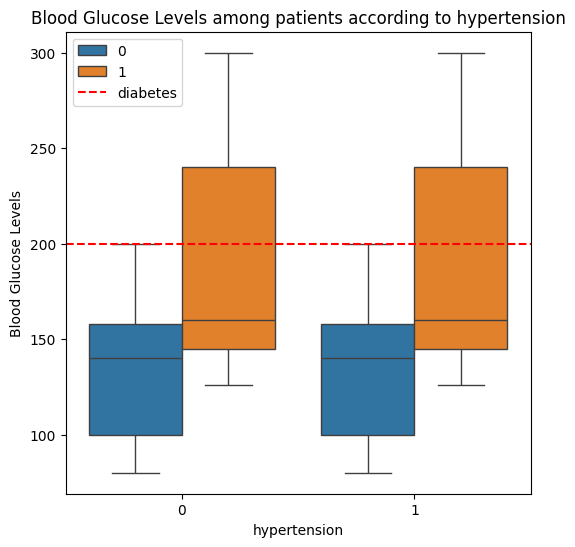

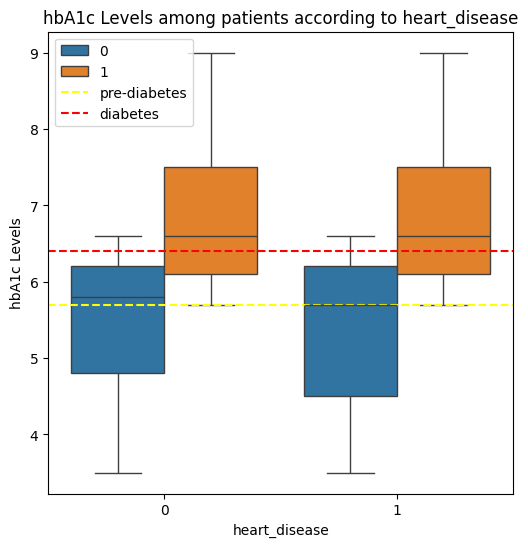

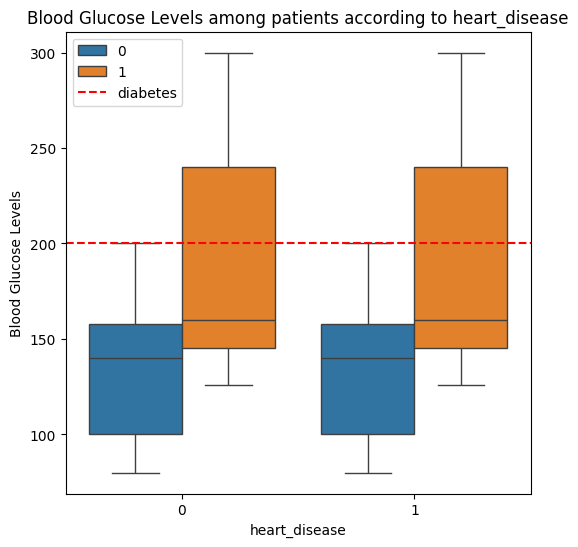

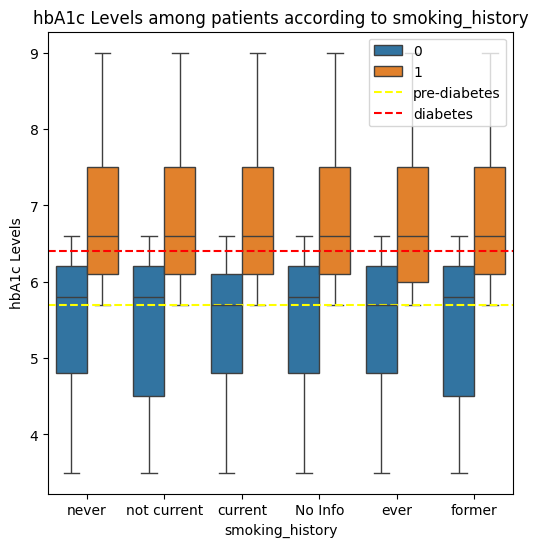

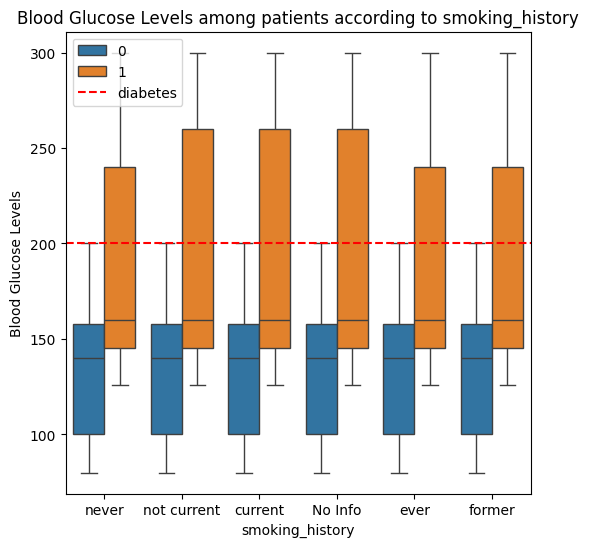

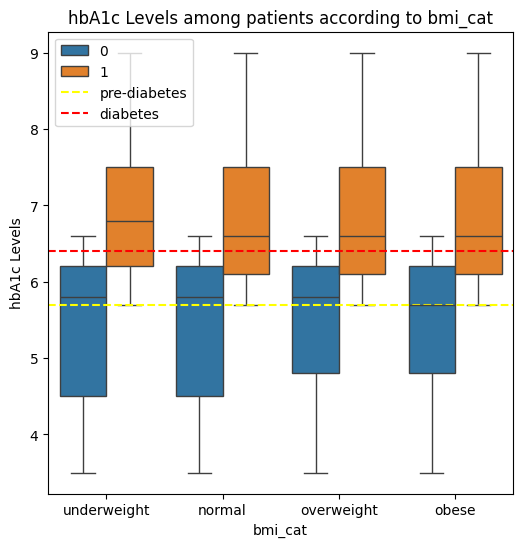

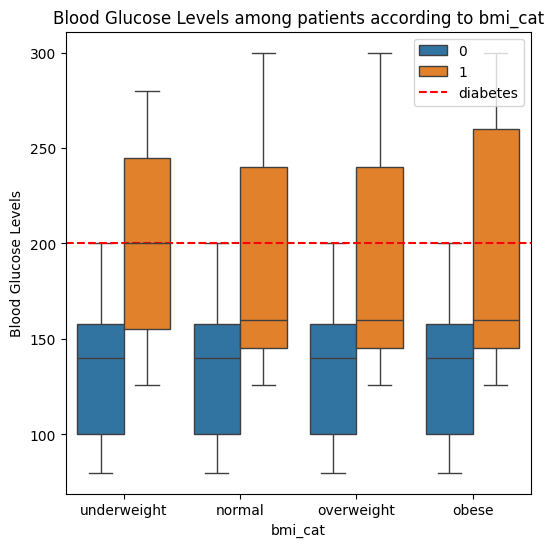

In [48]:
columns = ["gender", "race", "age_cat", "hypertension", "heart_disease", "smoking_history", "bmi_cat"]
for col in columns:
    plt.figure(figsize=(6, 6))
    h = sns.boxplot(data = df2, x = col, y = "hbA1c_level", hue = "diabetes")
    h.set_title(f"hbA1c Levels among patients according to {col}")
    h.set_xlabel(f"{col}")
    h.set_ylabel("hbA1c Levels")
    h.axhline(y = 5.7, c = "yellow", ls = "--",label = "pre-diabetes")
    h.axhline(y = 6.4, c = "red", ls = "--",label = "diabetes")
    h.legend()
    plt.show()

    plt.figure(figsize=(6, 6))
    g = sns.boxplot(data = df2, x = col, y = "blood_glucose_level", hue = "diabetes")
    g.set_title(f"Blood Glucose Levels among patients according to {col}")
    g.set_xlabel(f"{col}")
    g.set_ylabel("Blood Glucose Levels")
    g.axhline(y = 200, c = "red", ls = "--",label = "diabetes")
    g.legend()
    plt.show()

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


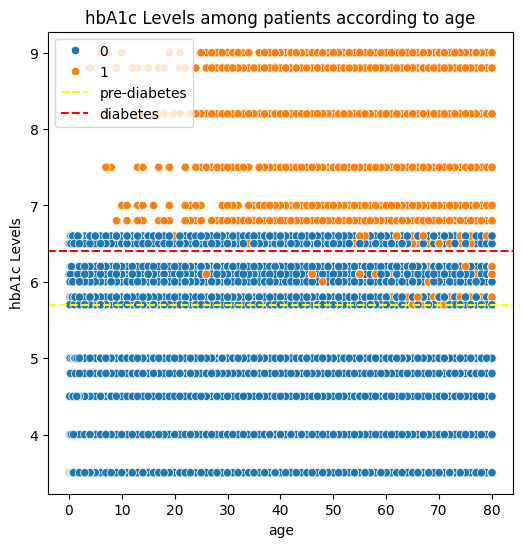

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


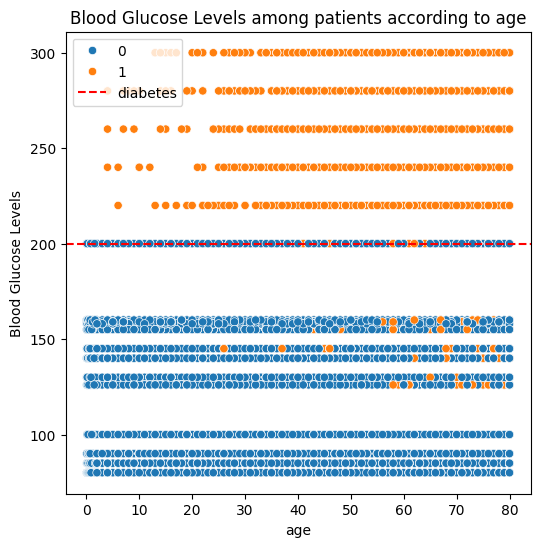

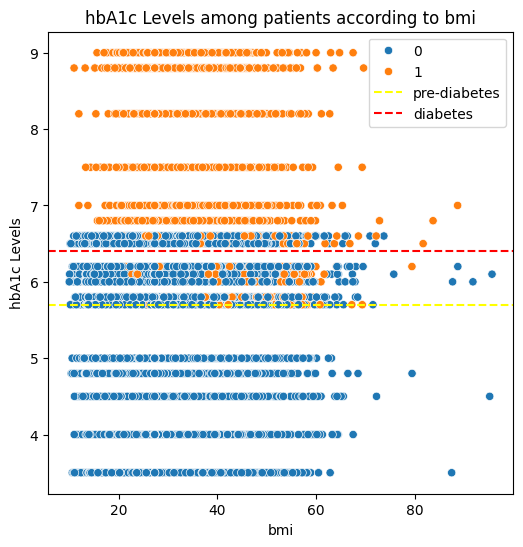

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


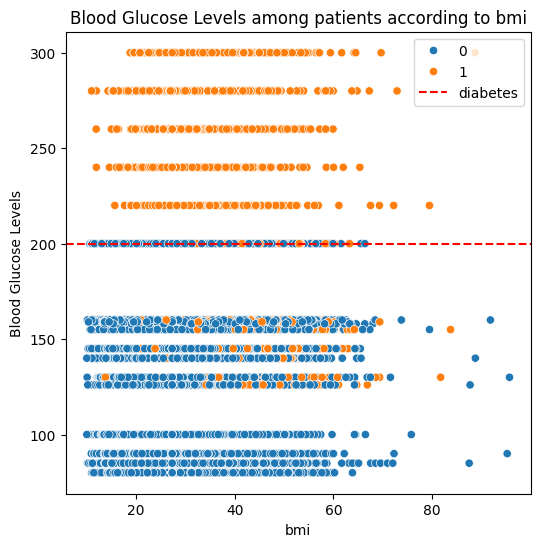

In [45]:
columns = ["age", "bmi"]
for col in columns:
    plt.figure(figsize=(6, 6))
    h = sns.scatterplot(data = df2, x = col, y = "hbA1c_level", hue = "diabetes")
    h.set_title(f"hbA1c Levels among patients according to {col}")
    h.set_xlabel(f"{col}")
    h.set_ylabel("hbA1c Levels")
    h.axhline(y = 5.7, c = "yellow", ls = "--",label = "pre-diabetes")
    h.axhline(y = 6.4, c = "red", ls = "--",label = "diabetes")
    h.legend()
    plt.show()

    plt.figure(figsize=(6, 6))
    g = sns.scatterplot(data = df2, x = col, y = "blood_glucose_level", hue = "diabetes")
    g.set_title(f"Blood Glucose Levels among patients according to {col}")
    g.set_xlabel(f"{col}")
    g.set_ylabel("Blood Glucose Levels")
    g.axhline(y = 200, c = "red", ls = "--",label = "diabetes")
    g.legend()
    plt.show()

In [36]:
columns = ["gender", "race", "age_cat", "location", "hypertension", "heart_disease", "smoking_history", "bmi_cat"]

from scipy.stats import chi2_contingency, chi2

for col in columns:
    contingency_table  = pd.crosstab(df2[col], df2['diabetes'])
    chi_square, p, dof, expected = chi2_contingency(contingency_table)
    critical_value = chi2.ppf(1 - 0.05, dof)
    if chi_square <= critical_value:
        print(f"There is no relationship between {col} and diabetes.")
    else:
        print(f"There is a relationship between {col} and diabetes.")

There is a relationship between gender and diabetes.
There is no relationship between race and diabetes.
There is a relationship between age_cat and diabetes.
There is no relationship between location and diabetes.
There is a relationship between hypertension and diabetes.
There is a relationship between heart_disease and diabetes.
There is a relationship between smoking_history and diabetes.
There is a relationship between bmi_cat and diabetes.


In [37]:
columns = ["gender", "age_cat", "hypertension", "heart_disease", "smoking_history", "bmi_cat"]

for col in columns:
    contingency_table  = pd.crosstab(df2[col], df2['diabetes'])
    contingency_table["total"] = contingency_table[0] + contingency_table[1]
    contingency_table["prop"] = contingency_table[1] / contingency_table["total"]
    at_risk = contingency_table[contingency_table["prop"] == contingency_table["prop"].max()].index[0]
    print(f"Most at risk of diabetes per {col}: {at_risk}")

Most at risk of diabetes per gender: Male
Most at risk of diabetes per age_cat: 65+
Most at risk of diabetes per hypertension: 1
Most at risk of diabetes per heart_disease: 1
Most at risk of diabetes per smoking_history: former
Most at risk of diabetes per bmi_cat: obese


# Splitting the Data into Training and Test Sets

In [38]:
X = df_encoded.drop(columns = ["year", "diabetes", "bmi_cat"])
y = df_encoded["diabetes"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Feature Scaling

In [39]:
scaler_X = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Logistic Regression

In [40]:
logit = LogisticRegression()
logit.fit(X_train_scaled, y_train)
y_logit = logit.predict(X_test_scaled)
acc_logit = accuracy_score(y_logit, y_test)
class_rep_logit = classification_report(y_logit, y_test)
print("accuracy: ", acc_logit)
print(class_rep_logit)

accuracy:  0.9609
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     18779
           1       0.63      0.88      0.73      1221

    accuracy                           0.96     20000
   macro avg       0.81      0.92      0.86     20000
weighted avg       0.97      0.96      0.96     20000



# Decision Tree

In [41]:
tree = DecisionTreeClassifier(random_state = 42)
tree.fit(X_train_scaled, y_train)
y_tree = tree.predict(X_test_scaled)
acc_tree = accuracy_score(y_tree, y_test)
class_rep_tree = classification_report(y_tree, y_test)
print("accuracy: ", acc_tree)
print(class_rep_tree)

accuracy:  0.94955
              precision    recall  f1-score   support

           0       0.97      0.98      0.97     18190
           1       0.74      0.69      0.71      1810

    accuracy                           0.95     20000
   macro avg       0.85      0.83      0.84     20000
weighted avg       0.95      0.95      0.95     20000



# Random Forest

In [42]:
rf = RandomForestClassifier(random_state = 42)
rf.fit(X_train_scaled, y_train)
y_rf = rf.predict(X_test_scaled)
acc_rf = accuracy_score(y_rf, y_test)
class_rep_rf = classification_report(y_rf, y_test)
print("accuracy: ", acc_rf)
print(class_rep_rf)

accuracy:  0.9717
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     18805
           1       0.68      0.98      0.80      1195

    accuracy                           0.97     20000
   macro avg       0.84      0.97      0.89     20000
weighted avg       0.98      0.97      0.97     20000

